The estimation of Feature Importance based on a Random Forest regression model.
After removing the features with correlation value higher than 0.99, analyzing on the input data of the model
was done to estimate the most important features  with respect to a Random Forest.

The Feature Importance is done according to two different approaches: 1.SHAP values which used to explain how each feature affects the model and 2.Random Forest Built-in Feature Importance which is based on reducing in impurity for Random Forest.

In [1]:
%load_ext jupyter_black

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap

from utils import get_clean_dataset

In [3]:
df = get_clean_dataset()

In [4]:
# df = df[df.DAM_perc_dmg != 0] a
# df

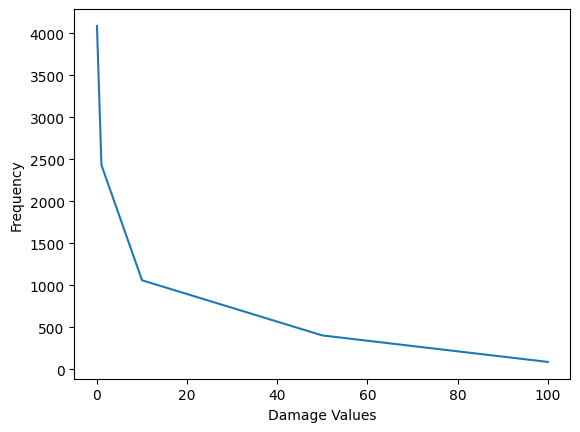

In [5]:
# The Old and New set of bins
# bins2= [0, 1, 60, 100]
bins2 = [0, 0.00009, 1, 10, 50, 100]
samples_per_bin2, binsP2 = np.histogram(df["DAM_perc_dmg"], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [6]:
print(samples_per_bin2)
print(binsP2)

[4086 2431 1061  405   90]
[0.e+00 9.e-05 1.e+00 1.e+01 5.e+01 1.e+02]


In [7]:
bin_index2 = np.digitize(df["DAM_perc_dmg"], bins=binsP2)

In [8]:
y_input_strat = bin_index2

In [9]:
# Dropping highly correlated features (correlation value > 0.99) from X data.
features = [
    "HAZ_rainfall_Total",
    "HAZ_rainfall_max_6h",
    "HAZ_rainfall_max_24h",
    "HAZ_v_max",
    "HAZ_v_max_3",
    "HAZ_dis_track_min",
    "GEN_landslide_per",
    "GEN_stormsurge_per",
    #'GEN_Bu_p_inSSA',
    #'GEN_Bu_p_LS',
    "GEN_Red_per_LSbldg",
    "GEN_Or_per_LSblg",
    "GEN_Yel_per_LSSAb",
    #'GEN_RED_per_SSAbldg',
    "GEN_OR_per_SSAbldg",
    "GEN_Yellow_per_LSbl",
    "TOP_mean_slope",
    "TOP_mean_elevation_m",
    "TOP_ruggedness_stdev",
    #'TOP_mean_ruggedness',
    #'TOP_slope_stdev',
    "VUL_poverty_perc",
    "GEN_with_coast",
    "GEN_coast_length",
    "VUL_Housing_Units",
    "VUL_StrongRoof_StrongWall",
    "VUL_StrongRoof_LightWall",
    "VUL_StrongRoof_SalvageWall",
    "VUL_LightRoof_StrongWall",
    "VUL_LightRoof_LightWall",
    "VUL_LightRoof_SalvageWall",
    "VUL_SalvagedRoof_StrongWall",
    "VUL_SalvagedRoof_LightWall",
    "VUL_SalvagedRoof_SalvageWall",
    "VUL_vulnerable_groups",
    "VUL_pantawid_pamilya_beneficiary",
]

X = df[features]
# display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df["DAM_perc_dmg"], stratify=y_input_strat, test_size=0.2
)


# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

In [10]:
# create an RandomForest regression model

rf = RandomForestRegressor(
    max_depth=None, n_estimators=100, min_samples_split=8, min_samples_leaf=5
)

rf_model = rf.fit(X_train, y_train)

In [11]:
X_train4shapely = pd.DataFrame(data=X_train, columns=features)

In [12]:
# compute SHAP values
explainer_rf = shap.Explainer(rf_model, X_train4shapely)
shap_values_rf = explainer_rf(X_train4shapely, check_additivity=False)

100%|===================| 6437/6458 [02:21<00:00]        

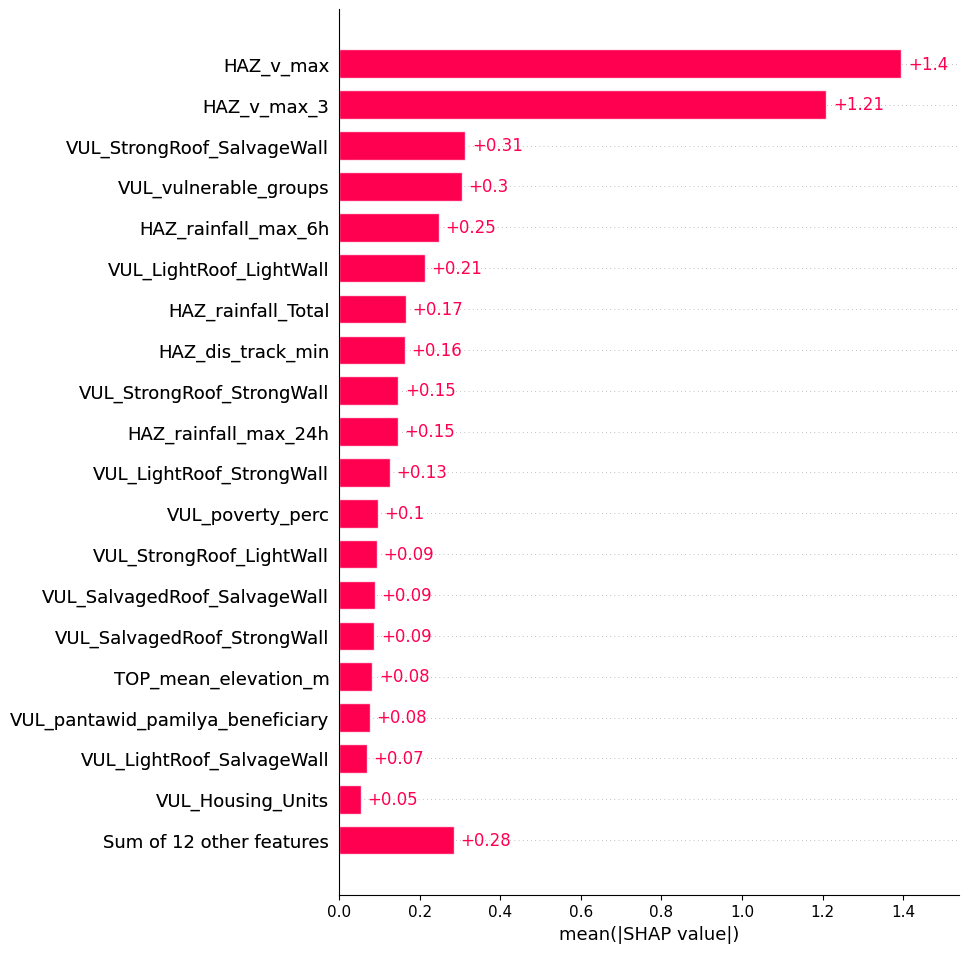

In [13]:
# Showing Barplot
# shap.plots.heatmap(shap_values_rf[:1000])

shap.plots.bar(shap_values_rf, max_display=20)

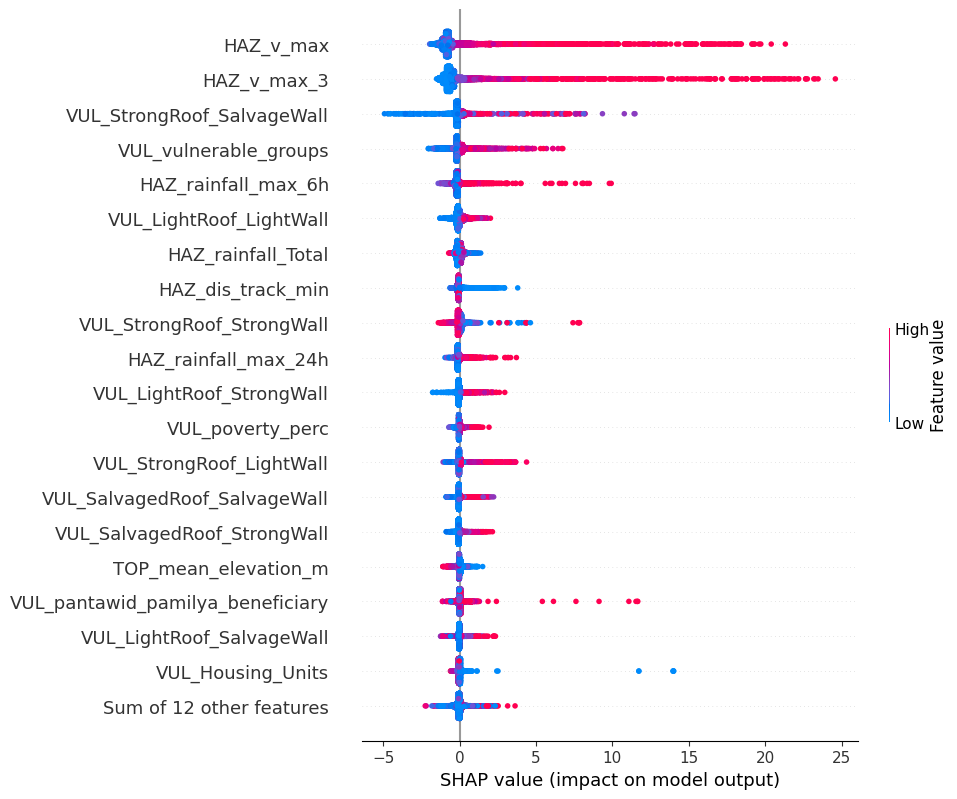

In [14]:
# Showing Beeswarm Plot
# shap.plots.beeswarm(shap_values_rf, max_display=20, order=shap_values_rf.abs.max(0)#, color="shap_red")

shap.plots.beeswarm(
    shap_values_rf,
    max_display=20,  # , color="shap_red",
)

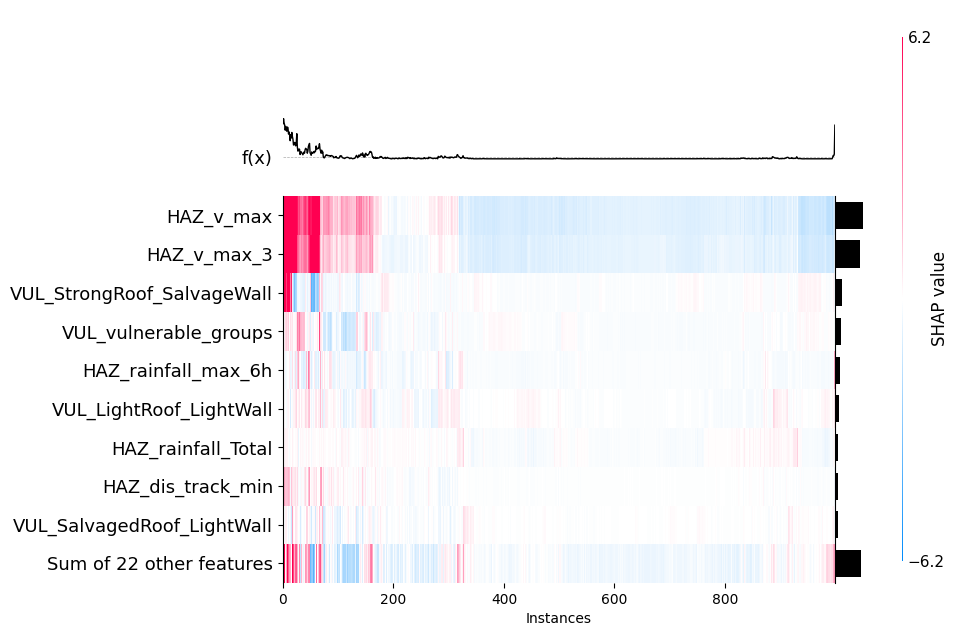

In [15]:
# Showing Heatmap
shap.plots.heatmap(shap_values_rf[:1000])

Text(0.5, 0, 'Random Forest Feature Importance')

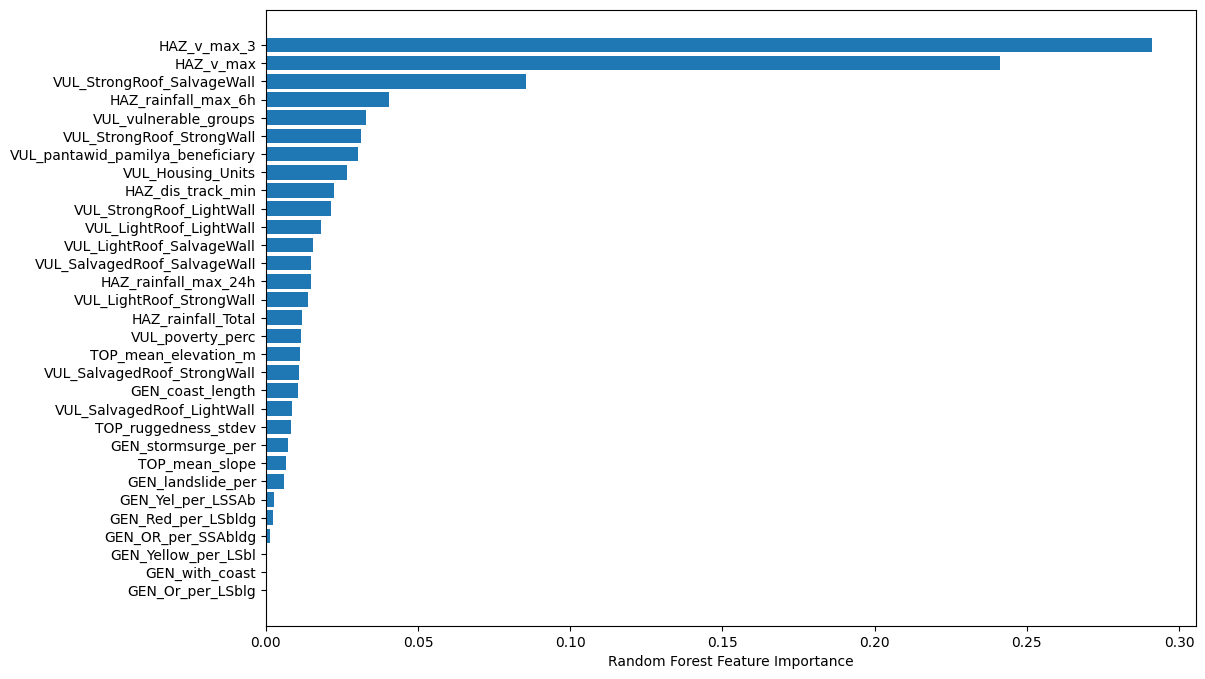

In [16]:
# Random Forest Built-in Feature Importance

plt.rcParams.update({"figure.figsize": (12.0, 8.0)})
plt.rcParams.update({"font.size": 10})

rf.feature_importances_

sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

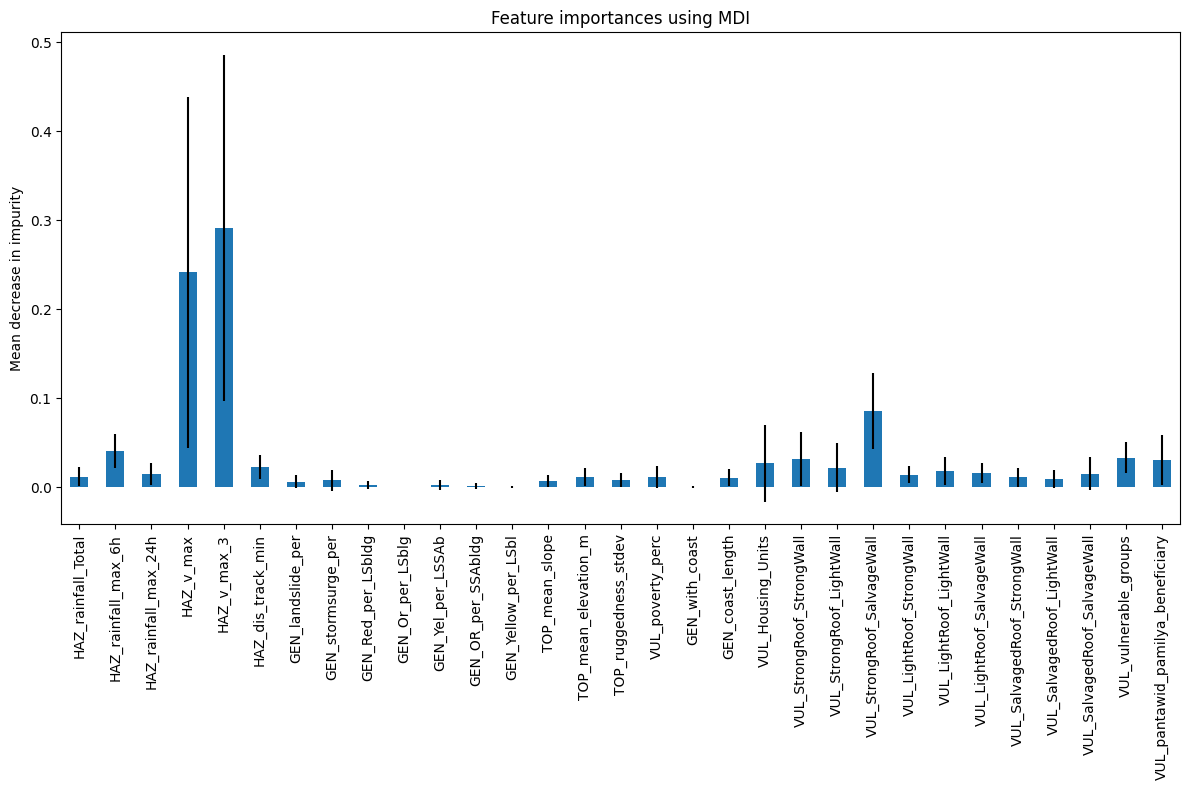

In [17]:
rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

importances = rf.feature_importances_
sorted_idx = rf.feature_importances_.argsort()
forest_importances = pd.Series(importances, index=X.columns)


fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
# forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [18]:
"""
Showing X data illustrates that 5 highly correlated features with the value higher than 0.99 were removed 
before applying feature importance methods on input data.
"""
X

,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Red_per_LSbldg,GEN_Or_per_LSblg,...,VUL_StrongRoof_LightWall,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary
0,185.828571,14.716071,7.381696,55.032241,166667.757548,2.478142,2.64,6.18,1.17,0.03,...,8.211552,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106
2,8.818750,0.455208,0.255319,8.728380,664.968323,288.358553,0.06,0.00,0.06,0.00,...,33.639236,0.850008,1.218595,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168
4,24.175000,2.408333,0.957639,10.945624,1311.358762,274.953818,1.52,1.28,0.02,0.00,...,22.963749,0.197179,0.667374,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651
6,14.930000,1.650000,0.586250,12.108701,1775.385328,252.828578,0.00,0.00,0.00,0.00,...,16.179723,0.279362,0.675125,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385
7,13.550000,1.054167,0.528125,10.660943,1211.676901,258.194381,5.52,0.36,0.00,0.00,...,32.522996,0.065703,0.821288,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,9.700000,0.408333,0.216146,8.136932,538.743551,277.107823,1.80,6.25,0.12,0.00,...,19.563863,0.186916,3.613707,32.492212,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411
25837,17.587500,1.414583,0.386458,9.818999,946.676507,305.789817,0.00,0.00,0.00,0.00,...,13.456446,0.209059,0.383275,4.703833,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551
25838,11.487500,0.614583,0.230319,15.791907,3938.254316,210.313249,0.06,0.09,0.06,0.00,...,22.347376,0.202748,0.090110,3.063753,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952
25839,11.600000,1.400000,0.412766,13.867145,2666.620370,218.189328,0.00,0.00,0.00,0.00,...,29.584121,0.000000,0.094518,3.119093,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166
